In [97]:
from astropy.io import fits
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import redh3p as rhp
from PIL import Image

from lmfit import Model

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import os
import ipynbname
nb_path = str(ipynbname.path())
spec_dir = os.path.join(os.path.abspath(nb_path + '/../../../'), 'spec/')

fits_path_36 = spec_dir+'order36/jun02s*'
fits_path_35 = spec_dir+'order35/jun02s*'
fits_path_37 = spec_dir+'order37/jun02s*'
header_path = spec_dir+'jun02s*'

order36_data = rhp.read_file(path=fits_path_36)
order35_data = rhp.read_file(path=fits_path_35)
order37_data = rhp.read_file(path=fits_path_37)

int0 = 22
flat0 = 32
flat1 = 41
dark0 = 22
dark1 = 31

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat0, stop=flat1, init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark0, stop=dark1, init=int0)

avg_flat_order35 = rhp.calc_avg(data=order35_data, start=flat0, stop=flat1, init=int0)
avg_dark_order35 = rhp.calc_avg(data=order35_data, start=dark0, stop=dark1, init=int0)

avg_flat_order37 = rhp.calc_avg(data=order37_data, start=flat0, stop=flat1, init=int0)
avg_dark_order37 = rhp.calc_avg(data=order37_data, start=dark0, stop=dark1, init=int0)

spec36_reducelist = []
spec35_reducelist = []
spec37_reducelist = []

sky_frame = [51,59,60,72,78,79,91,103]

for fn in range(60, 104):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe35 = rhp.scale_sky_frame(data=order35_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe37 = rhp.scale_sky_frame(data=order37_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        
        reduce_spec36 = (order36_data[fn-int0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
        
        reduce_spec35 = (order35_data[fn-int0] - skyframe35) / (avg_flat_order35 - avg_dark_order35)
        reduce_spec35[reduce_spec35<0] = 0
#         reduce_spec35 = np.delete(reduce_spec35, np.s_[:8], 0)
        
        reduce_spec37 = (order37_data[fn-int0] - skyframe37) / (avg_flat_order37 - avg_dark_order37)
        reduce_spec37[reduce_spec37<0] = 0
#         reduce_spec37 = np.vstack((reduce_spec37, np.zeros((7, 1024))))
    
        spec36_reducelist.append(reduce_spec36)
        spec35_reducelist.append(reduce_spec35)
        spec37_reducelist.append(reduce_spec37)
        
spec36_reduced = np.array(spec36_reducelist)
spec35_reduced = np.array(spec35_reducelist)
spec37_reduced = np.array(spec37_reducelist)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange35 = fits.open(spec_dir + 'order35/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange37 = fits.open(spec_dir + 'order37/' + 'waverange.fits', ignore_missing_end=True)[0].data

R36 = 73194.84858495607
R35 = 73234.23454151815
R37 = 72736.04543958924
R = np.mean((R36,R35,R37))

In [98]:
modeA36 = order36_data[104-int0] + order36_data[107-int0] +\
        order36_data[108-int0] + order36_data[111-int0]
modeB36 = order36_data[105-int0] + order36_data[106-int0] +\
        order36_data[109-int0] + order36_data[110-int0]

modeA35 = order35_data[104-int0] + order35_data[107-int0] +\
        order35_data[108-int0] + order35_data[111-int0]
modeB35 = order35_data[105-int0] + order35_data[106-int0] +\
        order35_data[109-int0] + order35_data[110-int0]

modeA37 = order37_data[104-int0] + order37_data[107-int0] +\
        order37_data[108-int0] + order37_data[111-int0]
modeB37 = order37_data[105-int0] + order37_data[106-int0] +\
        order37_data[109-int0] + order37_data[110-int0]

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star

modeAB35 = ((modeA35 - modeB35)/4)/(avg_flat_order35 - avg_dark_order35)/exp_star

modeAB37 = ((modeA37 - modeB37)/4)/(avg_flat_order37 - avg_dark_order37)/exp_star

flux36_model = Model(rhp.gaussian_fit)
flux35_model = Model(rhp.gaussian_fit)
flux37_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.003, min=0, max=0.01)
flux36_params.add('a1', value=36)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

flux35_params = flux35_model.make_params()
flux35_params.add('a0', value=0.003, min=0, max=0.01)
flux35_params.add('a1', value=42)
flux35_params.add('a2', value=2, min=0.5, max=5)
flux35_params.add('a3', value=0)
flux35_params.add('a4', value=0)
flux35_params.add('a5', value=0)

flux37_params = flux37_model.make_params()
flux37_params.add('a0', value=0.003, min=0, max=0.01)
flux37_params.add('a1', value=38)
flux37_params.add('a2', value=2, min=0.5, max=5)
flux37_params.add('a3', value=0)
flux37_params.add('a4', value=0)
flux37_params.add('a5', value=0)

lower = 0
upper = 1024

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))

star35_a0 = np.zeros(np.size(modeAB35,1))
star35_a2 = np.zeros(np.size(modeAB35,1))

star37_a0 = np.zeros(np.size(modeAB37,1))
star37_a2 = np.zeros(np.size(modeAB37,1))

spat_ax36 = np.linspace(0, modeAB36.shape[0]-1, modeAB36.shape[0])
spat_ax35 = np.linspace(0, modeAB35.shape[0]-1, modeAB35.shape[0])
spat_ax37 = np.linspace(0, modeAB37.shape[0]-1, modeAB37.shape[0])

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_ax36)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
        
    try:
        flux35_fit_result = flux35_model.fit(modeAB35.T[i], flux35_params, x=spat_ax35)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order35')
        
    try:
        flux37_fit_result = flux37_model.fit(modeAB37.T[i], flux37_params, x=spat_ax37)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order37')
        
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    
    star35_a0[i] = flux35_fit_result.params['a0'].value
    star35_a2[i] = flux35_fit_result.params['a2'].value
    
    star37_a0[i] = flux37_fit_result.params['a0'].value
    star37_a2[i] = flux37_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10 # alpha Lyrae in atmospheric window 2.2 mu m
m_lambda = 6.749 # Kmag HD 131885
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))

Fbb35 = F_a0 * ((lambda_aw/waverange35)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange35*T)) - 1))

Fbb37 = F_a0 * ((lambda_aw/waverange37)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange37*T)) - 1))

star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm

star35_fwhm = star35_a2*(np.sqrt(2*np.log(2))*2)
Fobs35 = star35_a0 * star35_fwhm

star37_fwhm = star37_a2*(np.sqrt(2*np.log(2))*2)
Fobs37 = star37_a0 * star37_fwhm

Fc36 = Fbb36/Fobs36

Fc35 = Fbb35/Fobs35

Fc37 = Fbb37/Fobs37

width36 = spec36_reduced.shape[1]
length36 = spec36_reduced.shape[2]

width35 = spec35_reduced.shape[1]
length35 = spec35_reduced.shape[2]

width37 = spec37_reduced.shape[1]
length37 = spec37_reduced.shape[2]

slit_area36 = 0.1 * width36 * 2.908e-5 * length36

slit_area35 = 0.1 * width35 * 2.999e-5 * length35

slit_area37 = 0.1 * width37 * 2.859e-5 * length37

exp_spec = 60

fjc36_list = []
fjc35_list = []
fjc37_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    fjc35_list.append(spec35_reduced[i] / exp_spec * Fc35 * 4.2535e10 / slit_area35)
    fjc37_list.append(spec37_reduced[i] / exp_spec * Fc37 * 4.2535e10 / slit_area37)
    
fjc36 = np.array(fjc36_list)
fjc35 = np.array(fjc35_list)
fjc37 = np.array(fjc37_list)

In [200]:
width36 = np.size(spec36_reduced, axis=1)
length36 = np.size(spec36_reduced, axis=2)

In [201]:
width36

141

In [203]:
spec36_reduced.shape[1]

141

In [105]:
fjc37.shape

(38, 146, 1024)

In [103]:
fjc36.shape

(38, 141, 1024)

In [104]:
fjc35.shape

(38, 145, 1024)

Text(0, 0.5, 'Frame Number')

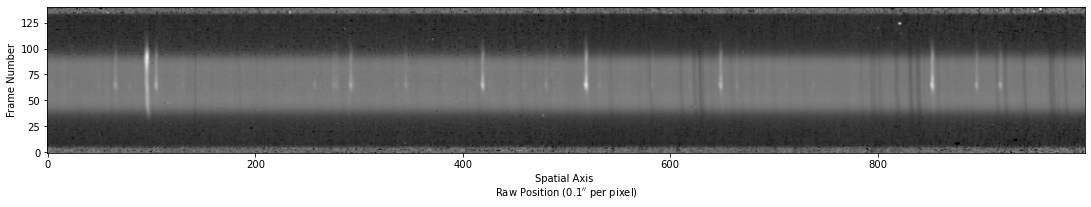

In [102]:
spt = np.delete(fjc36[0], np.s_[1000:], axis=1)
x = waverange35[0:1000]

fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spt, cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3), origin='lower')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')

In [138]:
fjc36.shape

(38, 141, 1024)

In [119]:
np.ones(1024)*1.875

array([1.875, 1.875, 1.875, ..., 1.875, 1.875, 1.875])

In [130]:
res

array([[ 3.22596261e-03,  3.01488707e-03,  2.69648215e-03, ...,
         6.08755805e-02,  5.29374164e-02,  6.59205992e-02],
       [ 3.59178553e-03,  3.95511005e-03,  3.01317780e-03, ...,
         6.04663908e-02,  5.24570033e-02,  6.52573268e-02],
       [ 3.75563952e-03,  4.55391607e-03,  3.52951045e-03, ...,
         5.40302953e-02,  4.68716717e-02,  5.81551973e-02],
       ...,
       [ 4.95460387e-03,  4.92663075e-03,  5.16277460e-03, ...,
         3.83095829e-02,  5.48315874e-02,  5.15974678e-02],
       [ 5.10345797e-03,  4.04833995e-03,  6.09197778e-03, ...,
         2.55534926e-02,  2.88061818e-02,  2.57146209e-02],
       [ 4.05143037e-03,  1.90413240e-03,  5.80587340e-03, ...,
         8.98647811e-03,  2.17143377e-18, -2.39772259e-18]])

In [187]:
import scipy as sp

res = sp.ndimage.zoom(fjc36, [1,zoom_fac36,1], mode='nearest')

newspt = np.delete(res[0], np.s_[1000:], axis=1)

In [188]:
res.shape

(38, 267, 1024)

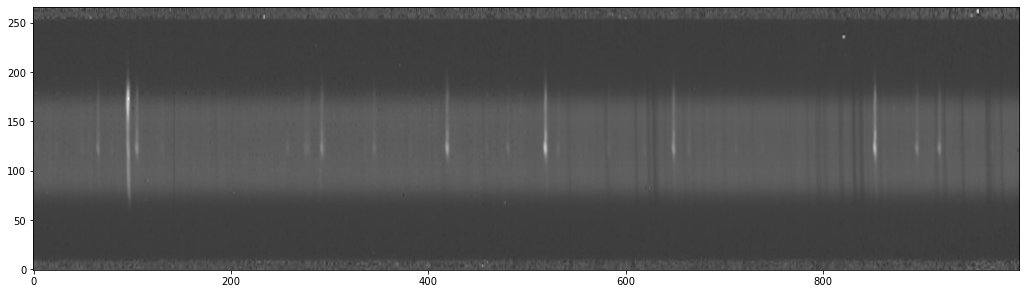

In [189]:
fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(newspt, cmap='gist_gray', norm=colors.PowerNorm(gamma=0.5), origin='lower')

In [64]:
modeA36 = order36_data[104-int0] + order36_data[107-int0] +\
        order36_data[108-int0] + order36_data[111-int0]
modeB36 = order36_data[105-int0] + order36_data[106-int0] +\
        order36_data[109-int0] + order36_data[110-int0]

modeA35 = order35_data[104-int0] + order35_data[107-int0] +\
        order35_data[108-int0] + order35_data[111-int0]
modeB35 = order35_data[105-int0] + order35_data[106-int0] +\
        order35_data[109-int0] + order35_data[110-int0]

modeA37 = order37_data[104-int0] + order37_data[107-int0] +\
        order37_data[108-int0] + order37_data[111-int0]
modeB37 = order37_data[105-int0] + order37_data[106-int0] +\
        order37_data[109-int0] + order37_data[110-int0]

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star

modeAB35 = ((modeA35 - modeB35)/4)/(avg_flat_order35 - avg_dark_order35)/exp_star

modeAB37 = ((modeA37 - modeB37)/4)/(avg_flat_order37 - avg_dark_order37)/exp_star

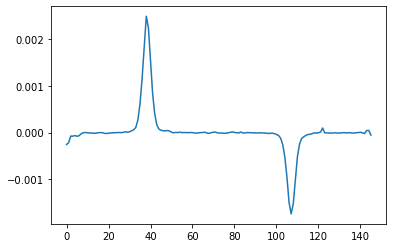

In [166]:
plt.plot(modeAB37.T[200])

In [210]:
RA_modeA = 224.23866
RA_modeB = 224.24037
DEC_modeA = -26.28654
DEC_modeB = -26.28358

arcsec_diff_star = np.sqrt(((RA_modeA-RA_modeB)*3600)**2 + ((DEC_modeA-DEC_modeB)*3600)**2)
arcsec_per_pix_new = 0.1

pix_diff_star36 = np.where(modeAB36.T[200]==np.min(modeAB36.T[200]))[0][0] -\
    np.where(modeAB36.T[200]==np.max(modeAB36.T[200]))[0][0]

zoom_fac36 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star36

pix_diff_star35 = np.where(modeAB35.T[200]==np.min(modeAB35.T[200]))[0][0] -\
    np.where(modeAB35.T[200]==np.max(modeAB35.T[200]))[0][0]

zoom_fac35 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star35

pix_diff_star37 = np.where(modeAB37.T[200]==np.min(modeAB37.T[200]))[0][0] -\
    np.where(modeAB37.T[200]==np.max(modeAB37.T[200]))[0][0]

zoom_fac37 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star37

In [211]:
zoom_fac36, zoom_fac35, zoom_fac37

(1.8932872511544623, 1.9228698644537507, 1.7835314684788413)

In [169]:
np.where(modeAB36.T[200]==np.min(modeAB36.T[200]))

(array([101]),)

In [172]:
pix_diff_star36 = np.where(modeAB36.T[200]==np.min(modeAB36.T[200]))[0][0] -\
    np.where(modeAB36.T[200]==np.max(modeAB36.T[200]))[0][0]

65

In [207]:
pix_diff_star37 = np.where(modeAB37.T[200]==np.min(modeAB37.T[200]))[0][0] -\
    np.where(modeAB37.T[200]==np.max(modeAB37.T[200]))[0][0]
zoom_fac37 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star37
zoom_fac37

1.7835314684788413

In [208]:
(arcsec_diff_star/arcsec_per_pix_new)

123.06367132504005

In [209]:
123.06367132504005/69

1.7835314684788413

In [206]:
(arcsec_diff_star/arcsec_per_pix_new)/64

1.9228698644537507

In [212]:
np.where(modeAB36.T[200]==np.min(modeAB36.T[200]))[0][0] -\
    np.where(modeAB36.T[200]==np.max(modeAB36.T[200]))[0][0]

65

In [213]:
np.where(modeAB35.T[200]==np.min(modeAB35.T[200]))[0][0] - np.where(modeAB35.T[200]==np.max(modeAB35.T[200]))[0][0]

64

In [168]:
np.where(modeAB37.T[200]==np.min(modeAB37.T[200]))[0][0] - np.where(modeAB37.T[200]==np.max(modeAB37.T[200]))[0][0]

69

In [174]:
modeAB36.shape[0]

141

In [7]:
spec35_reduced[0].shape

(145, 1024)

In [106]:
120/64

1.875

In [139]:
120/68

1.7647058823529411

In [175]:
123/65*141

266.81538461538463

In [141]:
0.288/0.1*141

406.0799999999999

In [8]:
new_size37 = 120/68*146

new_size36 = 120/64*141

new_size35 = 120/64*145

264.375